https://python.langchain.com/docs/how_to/custom_tools/

In [1]:
from getpass import getpass

In [2]:
OPENAI_API_KEY = getpass(prompt='Enter your OpenAI Token:')

Enter your OpenAI Token: ········


In [17]:
import os
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from langchain.agents import tool

In [5]:
@tool 
def get_rdf_CN(chemical_symbol: str, trj_dir: str) -> str:
    """Returns radial distribution of a given chemical symbol in bulk water with this path file to trajectory folder"""
    for f in os.listdir(trj_dir):
        if f.endswith('.dcd'):
            dcd_file = os.path.join(trj_dir, f)
        elif f.endswith('.pdb'):
            pdb_file = os.path.join(trj_dir, f)
    mol = md.load_dcd(dcd_file,top=pdb_file)
    # mol = md.load_dtr(dtr_file,top=pdb_file)
    mol.xyz *= 10 # convert coordinates from nm to A
    mol.unitcell_lengths *= 10 # convert box dimensions from nm to A
    num_frames = mol.n_frames
    top = mol.topology

    Er_Water = top.select_pairs("element == "+chemical_symbol, "resname SPC and element==O")

    bin_w = 0.01
    rho = 0.033
    bins = np.arange(0, 10, bin_w)
    bin_centers = (bins[:-1] + bins[1:])/2.0
    dr = bin_centers[1]-bin_centers[0]

    #Er_water
    distance_Er_O_water = md.compute_distances(mol, Er_Water)
    rdf_Er_water, lengths = np.histogram(distance_Er_O_water, bins = bins)

    #rdf
    rdf_Er_water = rdf_Er_water.astype('float64')
    rdf_Er_water /= num_frames 
    shell_vol = 4/3 * np.pi * (lengths[1:]**3 - lengths[:-1]**3) * rho
    rdf_Er_water /= shell_vol

    CN_Er_water = []
    tmp = 0
    for i in range(len(bin_centers)):
        tmp += 4*np.pi*rho*dr*np.power(bin_centers[i],2)*rdf_Er_water[i]
        CN_Er_water.append(tmp)

    fig, ax = plt.subplots(figsize=(4,3), dpi=200)
    ax.set_xlim([2,6])
    ax.set_ylim([0,18])
    ax.plot(bin_centers, rdf_Er_water)
    ax.set_ylabel('$g(r)$')
    ax1 = ax.twinx()
    ax1.plot(bin_centers, CN_Er_water, color = 'r')
    ax1.set_ylim([0,35])
    ax1.set_ylabel('Coordination number')
    ax.set_xlabel('r ($\AA$)')
    return ax

<>:49: SyntaxWarning: invalid escape sequence '\A'
<>:49: SyntaxWarning: invalid escape sequence '\A'
/var/folders/xr/v7wh_8z52fv7djcpd9ylm8h80000gn/T/ipykernel_29463/2461187749.py:49: SyntaxWarning: invalid escape sequence '\A'
  ax.set_xlabel('r ($\AA$)')


<Axes: xlabel='r ($\\AA$)', ylabel='$g(r)$'>

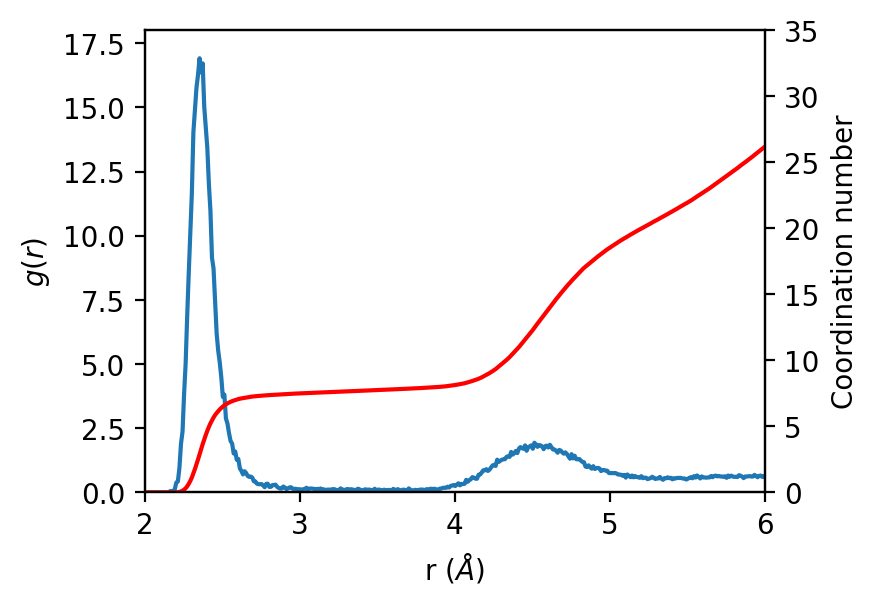

In [6]:
el = "Er"
trj_dir = "data"
get_rdf_CN.invoke({"chemical_symbol": el, "trj_dir":trj_dir})

In [7]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0, openai_api_key=OPENAI_API_KEY)

In [8]:
tools = [get_rdf_CN]

In [9]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            # "You are very powerful assistant, but don't know current events.",
            "You are very powerful assistant, but don't know current events. For each query vailidate that it contains a chemical element and otherwise cancel.",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

In [10]:
llm_with_tools = llm.bind_tools(tools)

In [11]:
from langchain.agents.format_scratchpad.openai_tools import (
    format_to_openai_tool_messages,
)
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser

agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_tool_messages(
            x["intermediate_steps"]
        ),
    }
    | prompt
    | llm_with_tools
    | OpenAIToolsAgentOutputParser()
)

In [12]:
from langchain.agents import AgentExecutor

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)



> Entering new AgentExecutor chain...

Invoking: `get_rdf_CN` with `{'chemical_symbol': 'Er', 'trj_dir': 'data'}`


Axes(0.125,0.11;0.775x0.77)Here is the radial distribution function (rdf) plot of Erbium in bulk water using the trajectory data in the specified folder.

> Finished chain.


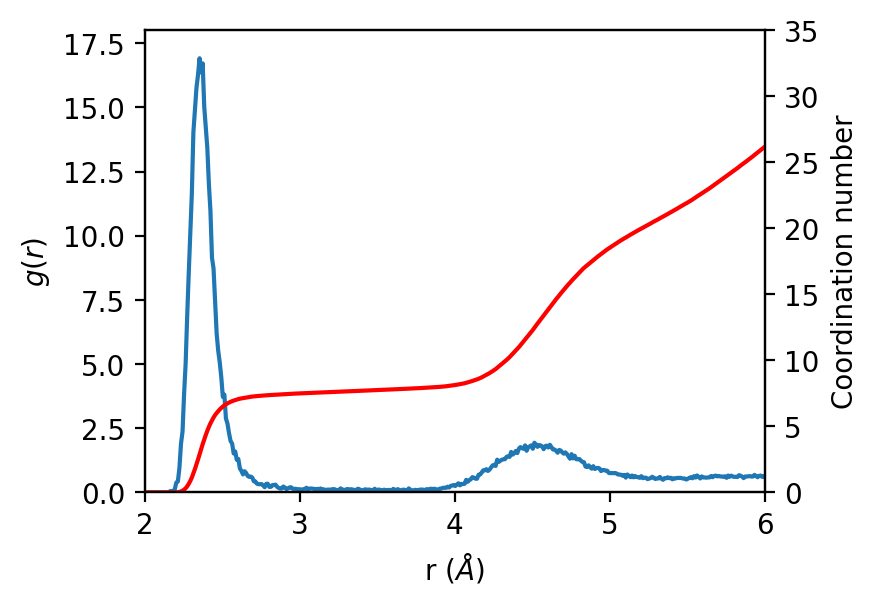

In [13]:
lst = list(agent_executor.stream({"input": "Plot the rdf of Erbium using trajectory in folder data "}))  # Yeah this worked !!

In [14]:
lst[0]

{'actions': [ToolAgentAction(tool='get_rdf_CN', tool_input={'chemical_symbol': 'Er', 'trj_dir': 'data'}, log="\nInvoking: `get_rdf_CN` with `{'chemical_symbol': 'Er', 'trj_dir': 'data'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_MF0uo5B2bd4HlikmeIkT4DnV', 'function': {'arguments': '{"chemical_symbol":"Er","trj_dir":"data"}', 'name': 'get_rdf_CN'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'}, id='run-182a3a34-8b89-4077-a719-b3f220d6e933', tool_calls=[{'name': 'get_rdf_CN', 'args': {'chemical_symbol': 'Er', 'trj_dir': 'data'}, 'id': 'call_MF0uo5B2bd4HlikmeIkT4DnV'}], tool_call_chunks=[{'name': 'get_rdf_CN', 'args': '{"chemical_symbol":"Er","trj_dir":"data"}', 'id': 'call_MF0uo5B2bd4HlikmeIkT4DnV', 'index': 0}])], tool_call_id='call_MF0uo5B2bd4HlikmeIkT4DnV')],
 'messages': [AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_MF0uo5B2bd4HlikmeIkT4DnV', 'function'

In [15]:
lst[1]

{'steps': [AgentStep(action=ToolAgentAction(tool='get_rdf_CN', tool_input={'chemical_symbol': 'Er', 'trj_dir': 'data'}, log="\nInvoking: `get_rdf_CN` with `{'chemical_symbol': 'Er', 'trj_dir': 'data'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_MF0uo5B2bd4HlikmeIkT4DnV', 'function': {'arguments': '{"chemical_symbol":"Er","trj_dir":"data"}', 'name': 'get_rdf_CN'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'}, id='run-182a3a34-8b89-4077-a719-b3f220d6e933', tool_calls=[{'name': 'get_rdf_CN', 'args': {'chemical_symbol': 'Er', 'trj_dir': 'data'}, 'id': 'call_MF0uo5B2bd4HlikmeIkT4DnV'}], tool_call_chunks=[{'name': 'get_rdf_CN', 'args': '{"chemical_symbol":"Er","trj_dir":"data"}', 'id': 'call_MF0uo5B2bd4HlikmeIkT4DnV', 'index': 0}])], tool_call_id='call_MF0uo5B2bd4HlikmeIkT4DnV'), observation=<Axes: xlabel='r ($\\AA$)', ylabel='$g(r)$'>)],
 'messages': [FunctionMessage(content='Axes(0.125,0.11;0.775x0.

In [16]:
lst[2]

{'output': 'Here is the radial distribution function (rdf) plot of Erbium in bulk water using the trajectory data in the specified folder.',
 'messages': [AIMessage(content='Here is the radial distribution function (rdf) plot of Erbium in bulk water using the trajectory data in the specified folder.')]}